#Extracting embeddings of movie plots with BERT

## Introduzione
L'obiettivo dello studio proposto è quello di utilizzare il modello BERT per creare degli embeddings i tweets di SENTIPOLC.

Se si esegue il notebook per la prima volta, si consiglia di seguire la struttura proposta, pensata appositamente per mostrare tutti gli step da eseguire per una corretta implementazione di Bert; alternativamente, è possibile procedere come di seguito:
 

1.   esecuzione delle prime celle per istanziare le librerie 
2.   importazione del dataset preprocessato
3.   tokenizzazione
4.   Estrazione embeddings mediante le procedure complete proposte, dipendemente dalla metodologia che si vuole adottare per ottenere l' *embedding*





# Installazione delle librerie

In [1]:
!pip install pytorch-pretrained-bert

In [2]:
!pip install tensorflow-gpu==1.15

# Preprocessing Dataset
## Importazione del dataset e analisi

Definizione di un metodo che permetta di reperire i files dal nostro Google Drive senza necessità di utilizzare il mount, ma specificando unicamente l'id del file  di interesse. [Qui](https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/) la  guida utilizzata per ottenere gli id di interesse.

In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def get_from_drive (file_id,file_name):
  # Authenticate and create the PyDrive client.
  # This only needs to be done once per notebook.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Download a file based on its file ID.
  #
  # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(file_name)



In [4]:
import pandas
dataset_DF = pandas.read_csv("sentipolc16_test.csv")
print(dataset_DF)
print("colonne:   ")
print(dataset_DF.columns)

               idtwitter  ...                                               text
0     507074506880712705  ...  Tra 5 minuti presentazione piano scuola del go...
1     507075789456961536  ...  @matteorenzi: Alle 10 appuntamento su http://t...
2     507077511902425088  ...  #labuonascuola gli #evangelisti #digitali non ...
3     507079183315787777  ...  Riforma scuola Tutto il discorso di  Renzi su ...
4     507080190225563648  ...  .@matteorenzi @MiurSocial #labuonascuola basta...
...                  ...  ...                                                ...
1995  645372190645481472  ...  Anche prodotti alimentari tipici pugliesi in v...
1996  645628412225265664  ...         intensità di vita  https://t.co/jv4aARxzhz
1997  645919232367161344  ...  Oggi tutti che iniziano l'università e io sul ...
1998  648567080107790336  ...  @GliIntoccabili @nonleggerlo Ma Ferrero? il co...
1999  648595040999239680  ...  Non vedi l'ora che venga qui, almeno lo sentir...

[2000 rows x 9 columns]
col

In [5]:
dataset_DF

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text
0,507074506880712705,0,0,0,0,0,0,2,Tra 5 minuti presentazione piano scuola del go...
1,507075789456961536,1,1,0,0,1,0,2,@matteorenzi: Alle 10 appuntamento su http://t...
2,507077511902425088,1,0,1,0,0,1,2,#labuonascuola gli #evangelisti #digitali non ...
3,507079183315787777,0,0,0,0,0,0,2,Riforma scuola Tutto il discorso di Renzi su ...
4,507080190225563648,1,0,0,0,0,0,2,.@matteorenzi @MiurSocial #labuonascuola basta...
...,...,...,...,...,...,...,...,...,...
1995,645372190645481472,0,0,0,0,0,0,3,Anche prodotti alimentari tipici pugliesi in v...
1996,645628412225265664,0,0,0,0,0,0,3,intensità di vita https://t.co/jv4aARxzhz
1997,645919232367161344,1,1,1,0,1,1,3,Oggi tutti che iniziano l'università e io sul ...
1998,648567080107790336,1,0,1,0,0,1,3,@GliIntoccabili @nonleggerlo Ma Ferrero? il co...


In [6]:
labels = []
for index, item in dataset_DF.iterrows():
  if item["opos"] == 0 and item["oneg"] == 0:
    labels.append("neutral")
  elif item["opos"] == 1 and item["oneg"] == 0:
    labels.append("pos")
  elif item["opos"] == 0 and item["oneg"] == 1:
    labels.append("neg")
  elif item["opos"] == 1 and item["oneg"] == 1:
    labels.append("mixed")
dataset_DF["label"] = labels

In [7]:
dataset_DF

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text,label
0,507074506880712705,0,0,0,0,0,0,2,Tra 5 minuti presentazione piano scuola del go...,neutral
1,507075789456961536,1,1,0,0,1,0,2,@matteorenzi: Alle 10 appuntamento su http://t...,pos
2,507077511902425088,1,0,1,0,0,1,2,#labuonascuola gli #evangelisti #digitali non ...,neg
3,507079183315787777,0,0,0,0,0,0,2,Riforma scuola Tutto il discorso di Renzi su ...,neutral
4,507080190225563648,1,0,0,0,0,0,2,.@matteorenzi @MiurSocial #labuonascuola basta...,neutral
...,...,...,...,...,...,...,...,...,...,...
1995,645372190645481472,0,0,0,0,0,0,3,Anche prodotti alimentari tipici pugliesi in v...,neutral
1996,645628412225265664,0,0,0,0,0,0,3,intensità di vita https://t.co/jv4aARxzhz,neutral
1997,645919232367161344,1,1,1,0,1,1,3,Oggi tutti che iniziano l'università e io sul ...,mixed
1998,648567080107790336,1,0,1,0,0,1,3,@GliIntoccabili @nonleggerlo Ma Ferrero? il co...,neg


In [8]:
dataset_DF=dataset_DF.drop("subj",axis=1)
dataset_DF=dataset_DF.drop("iro",axis=1)
dataset_DF=dataset_DF.drop("lpos",axis=1)
dataset_DF=dataset_DF.drop("lneg",axis=1)
dataset_DF=dataset_DF.drop("top",axis=1)

In [9]:
dataset_DF

,idtwitter,opos,oneg,text,label
0,507074506880712705,0,0,Tra 5 minuti presentazione piano scuola del go...,neutral
1,507075789456961536,1,0,@matteorenzi: Alle 10 appuntamento su http://t...,pos
2,507077511902425088,0,1,#labuonascuola gli #evangelisti #digitali non ...,neg
3,507079183315787777,0,0,Riforma scuola Tutto il discorso di Renzi su ...,neutral
4,507080190225563648,0,0,.@matteorenzi @MiurSocial #labuonascuola basta...,neutral
...,...,...,...,...,...
1995,645372190645481472,0,0,Anche prodotti alimentari tipici pugliesi in v...,neutral
1996,645628412225265664,0,0,intensità di vita https://t.co/jv4aARxzhz,neutral
1997,645919232367161344,1,1,Oggi tutti che iniziano l'università e io sul ...,mixed
1998,648567080107790336,0,1,@GliIntoccabili @nonleggerlo Ma Ferrero? il co...,neg


In [10]:
#PREPARE TRAINING SENTENCES
!pip install ekphrasis

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import pandas as pd
import numpy as np

text_processor = TextPreProcessor (
    # terms that will be normalized
    normalize=[ 'url' , 'email', 'user', 'percent', 'money', 'phone', 'time', 'date', 'number'] ,
    # terms that will be annotated
    annotate={"hashtag"} ,
    fix_html=True ,  # fix HTML tokens

    unpack_hashtags=True ,  # perform word segmentation on hashtags

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts = [ emoticons ]
)

Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...


In [11]:
#final examples training
examples = []

import re
for index, item in dataset_DF.iterrows():
    s = item["text"]
    s = s.lower()
    s = str(" ".join(text_processor.pre_process_doc(s)))
    s = re.sub(r"[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]", ' ', s)
    s = re.sub(r"\s+", ' ', s)
    s = re.sub(r'(\w)\1{2,}',r'\1\1', s)
    s = re.sub ( r'^\s' , '' , s )
    s = re.sub ( r'\s$' , '' , s )
    #print(s)
    examples.append(s)

dataset_DF["clean"] = examples

Per l'esperimento sarà necessario conservare la colonna relativa al plot, al titolo del libro, ed (eventualmente) un identificativo univoco.
Dal dataset ridotto, salvato in un nuovo dataframe, ricaviamo alcune utili statistiche per visualizzare eventuali null values.

In [12]:
import numpy as np

dataset_DF.replace("N/A", np.nan, inplace=True)
print("Null values dataset:")
print(dataset_DF.isnull().sum())

Null values dataset:
idtwitter    0
opos         0
oneg         0
text         0
label        0
clean        0
dtype: int64


Il dataset presenta **18 null values** per la colonna name; al momento procediamo con una rimozione delle istanze con null values.

In [13]:
print("Dimensioni del dataset preprocessato ma con null values: " + str(dataset_DF.shape))
dataset_DF.dropna(inplace=True)
print("Dimensioni del dataset preprocessato e privo di null values: " + str(dataset_DF.shape))
print("Null values dataset:")
print(dataset_DF.isnull().sum())

Dimensioni del dataset preprocessato ma con null values: (2000, 6)
Dimensioni del dataset preprocessato e privo di null values: (2000, 6)
Null values dataset:
idtwitter    0
opos         0
oneg         0
text         0
label        0
clean        0
dtype: int64


Importazione di google drive per salvare i files successivamente

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Effettuiamo il salvataggio del dataframe preprocessato per operazioni future.

In [15]:
import json
dataset_DF.to_csv('/content/drive/My Drive/sentipolc_test_processed.csv')

print("File salvato nella memoria di Google Drive")

File salvato nella memoria di Google Drive


## **Tokenizzazione**






In [16]:
import sys

!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
import tokenization

Importiamo le librerie necessarie alla inizializzazione del tokenizzatore di BERT; come si può notare dall'ultima riga dello stralcio di codice, sarà adottato il *BERT base uncased*

In [17]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
import numpy as np
# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)
  
# Load pre-trained model tokenizer (vocabulary)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = tokenization.FullTokenizer("vocab.txt", do_lower_case=True)


Procediamo con la tokenizzazione e con il calcolo della lunghezza media dei dei plot tokenizzati, così da poter appurare quale sarà l'input che andremo a offrire a BERT.
Tutti i plot tokenizzati saranno salvati in una lista chiamata *lista_plot_tokenized*


In [18]:
import time
dataset_reduced = dataset_DF
start_time = time.time()
lista_text_tokenized = []
lista_lunghezze = []
i = 0 #per tenere conto dell'indice del plot
over_128 = 0 #conteggio dei plots che superano i 512 tokens
for text in dataset_reduced["clean"]:
  i+=1
  marked_text=text
  tokenized_text = tokenizer.tokenize(marked_text)
  tokenized_text.insert(0,"[CLS]")
  tokenized_text.append("[SEP]")
  #print(tokenized_text)
  lista_text_tokenized.append(tokenized_text)
  lunghezza = len(tokenized_text)
  lista_lunghezze.append(lunghezza)
  #stampiamo solo i plots che eccedono nella lunghezza massima, pari a 512
  if lunghezza > 128:
    over_128+=1
  if (i%100)==0:
    print(str(i) + " text tokenizzati")
print("Tokenizzazione effettuata in: " + str(time.time() - start_time) + " secondi.")
print(lista_lunghezze)
media_plot = np.mean(lista_lunghezze)
print("Media lunghezza " + str(media_plot))
print("Deviazione std " + str(np.std(lista_lunghezze)))
print("# Text che superano i 128 caratteri: " + str(over_128))


100 text tokenizzati
200 text tokenizzati
300 text tokenizzati
400 text tokenizzati
500 text tokenizzati
600 text tokenizzati
700 text tokenizzati
800 text tokenizzati
900 text tokenizzati
1000 text tokenizzati
1100 text tokenizzati
1200 text tokenizzati
1300 text tokenizzati
1400 text tokenizzati
1500 text tokenizzati
1600 text tokenizzati
1700 text tokenizzati
1800 text tokenizzati
1900 text tokenizzati
2000 text tokenizzati
Tokenizzazione effettuata in: 0.6270203590393066 secondi.
[51, 64, 63, 38, 35, 57, 24, 33, 25, 55, 52, 45, 34, 35, 83, 38, 38, 13, 57, 34, 25, 51, 41, 35, 34, 57, 66, 44, 36, 60, 46, 25, 28, 73, 45, 63, 42, 50, 69, 35, 55, 23, 48, 56, 11, 34, 33, 30, 29, 31, 33, 26, 23, 37, 56, 30, 57, 42, 24, 18, 51, 17, 56, 22, 30, 22, 23, 49, 33, 54, 21, 32, 37, 26, 50, 14, 43, 33, 37, 21, 26, 18, 21, 34, 31, 69, 41, 45, 16, 42, 18, 25, 28, 35, 35, 23, 39, 23, 36, 44, 37, 18, 83, 20, 36, 31, 66, 30, 21, 33, 32, 47, 19, 57, 30, 25, 38, 55, 52, 12, 51, 21, 37, 50, 47, 27, 39, 21

### Riduzione tokens
BERT non accetta sequenze di token superiori ai 128, dunque è necessario tagliare le liste che eccedono in ciò.

In [19]:
i = 0
for tokenized_plot in lista_text_tokenized:
  if len(tokenized_plot) >= 127:
    tokenized_text_reduced = tokenized_plot[:127]
    tokenized_text_reduced.append("[SEP]")
    lista_text_tokenized[i] = tokenized_text_reduced
  i+=1

Eseguita la tokenizzazione, vanno indicizzati i tokens in base agli elementi presenti nel vocabolario di BERT e attribuiti dei segment ids a ogni token presente in una frase: analogamente al precedente stralcio di codice, salviamo tutte le liste di token indicizzati e segment ids in liste che permettano la **corrispondenza 1:1** tra gli elementi al loro interno e quelli presenti in *list_idexed_tokens*

### Indicizzazione tokens e segment ids

Le liste su cui andremo a ciclare, come accennato in precedenza, hanno una corrispondenza 1:1 tra tokens e indici del vocabolario di Bert 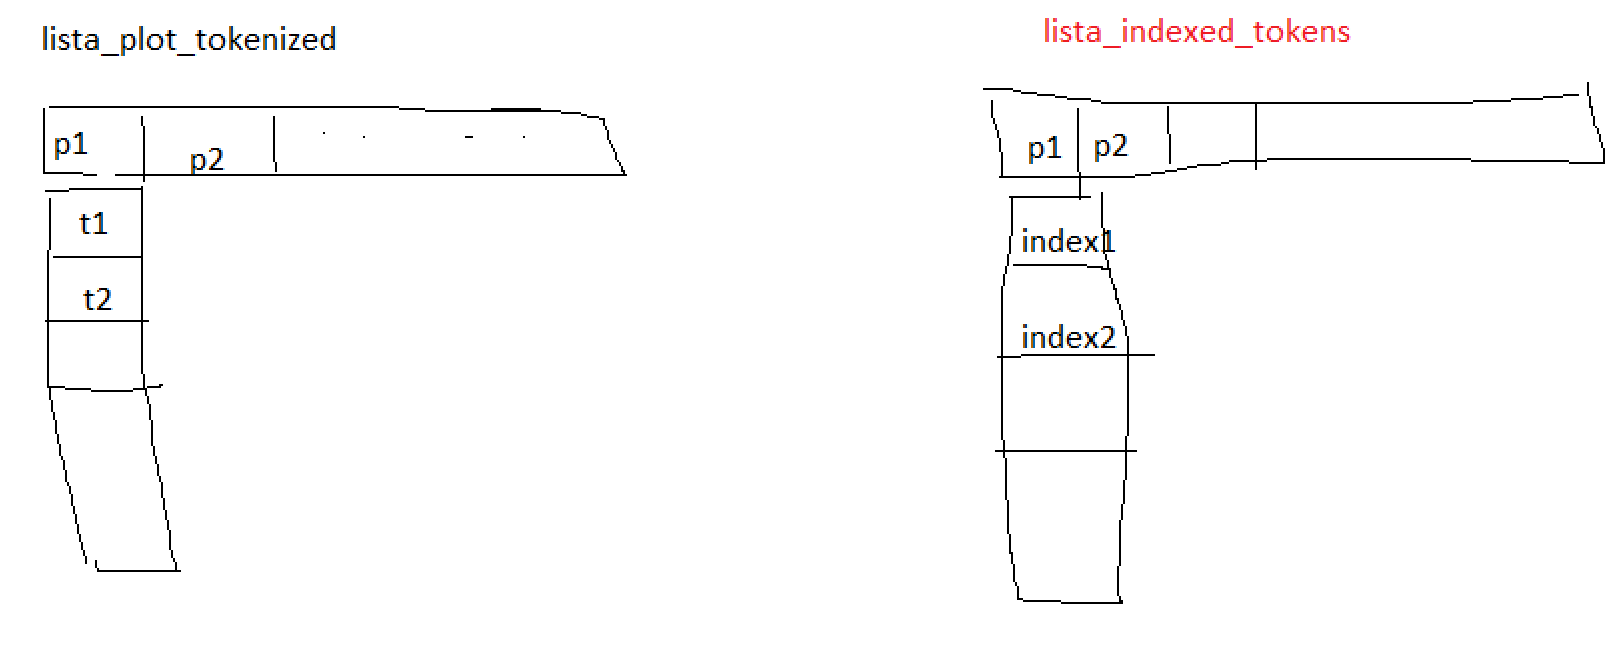

In [20]:
# Map the token strings to their vocabulary indeces.
list_indexed_tokens = [] #lista che ospiterà tutte le liste di tokens
list_segments_ids = []# lista che ospiterà i segment ids per ogni lista di tokens 
for plot_tokenized in lista_text_tokenized:
  list_indexed_tokens.append(tokenizer.convert_tokens_to_ids(plot_tokenized))
  list_segments_ids.append([1] * len(plot_tokenized))

# Display the words with their indeces.
for tup in zip(lista_text_tokenized[342], list_indexed_tokens[342]):
    print('{:<12} {:>6,}'.format(tup[0], tup[1])) #stampa di un plot di esempio
print("#tokens plot 343(342) = " + str(len(lista_text_tokenized[342])) + " # segment_ids " + str(len(list_segments_ids[342])))

[CLS]             2
<                 6
us            2,026
##er          2,270
>            127,748
grazie           32
per              22
le               40
sue             873
analisi       2,303
partecipi    10,532
anche            23
alla             34
<                 6
ha               53
##shtag      13,411
>            127,748
consult      25,200
azione        1,669
<                 6
/               110
ha               53
##shtag      13,411
>            127,748
<                 6
ha               53
##shtag      13,411
>            127,748
la               17
buona           159
scuola           81
<                 6
/               110
ha               53
##shtag      13,411
>            127,748
<                 6
us            2,026
##er          2,270
>            127,748
[SEP]             3
#tokens plot 343(342) = 41 # segment_ids 41


# Estrazione embeddings


## **Procedura completa**


In [21]:
!pip install transformers

In [22]:
from transformers import BertModel

In [23]:
embedding_list = []

In [24]:
import time
start_time = time.time()
lista_dizionari = []
model = BertModel.from_pretrained('m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0', output_hidden_states=True)
model.eval()
i = 0
for indexed_tokens in list_indexed_tokens:
  dizionario_embeddings = {}
  # para:esecuzione di bert
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_ids = list_segments_ids[i]
  segments_tensors = torch.tensor([segments_ids])

  with torch.no_grad():
      out = model(tokens_tensor, segments_tensors)
  encoded_layers = out.hidden_states
  ##################################################################

  # para: combining the layers in one big tensor
  #token_embeddings = torch.stack(encoded_layers, dim=0)
  ##################################################################

  # para: Removal of the batch dimension
  #token_embeddings = torch.squeeze(token_embeddings, dim=1)
  ##################################################################

  #para: swap dimensions layers and tokens
  #token_embeddings = token_embeddings.permute(1,0,2)
  ##################################################################

  #para: caso ultimo layer
  token_vecs = encoded_layers[11][0]
  #array_np = token_vecs.numpy()
  #print(array_np)
  #morevals = 128 - len(indexed_tokens)
  #for i in range(0,morevals):
  #  array_np = np.insert(array_np,-1, np.zeros(768),axis=0)
  embedding_list.append(token_vecs)
  #print(array_np.shape)
  # get last four layers
  #last_four_layers = [encoded_layers[i] for i in (-1, -2, -3, -4)]
  # cast layers to a tuple and concatenate over the last dimension
  #cat_hidden_states = torch.cat(tuple(last_four_layers), dim=-1)
 # print(cat_hidden_states.size())

  # take the mean of the concatenated vector over the token dimension
  #cat_sentence_embedding = torch.mean(cat_hidden_states, dim=1).squeeze()
  #print(cat_sentence_embedding)
  #print(cat_sentence_embedding.size())
 # print(token_vecs)
  #sentence_embedding_last_layer = torch.mean(token_vecs, dim=0)
  ##################################################################
  #embeddings_training.append(token_vecs)
  
  if (i%100) == 0:
    print(str(i+1) +  " plot completati")
  i+=1
  #if i==10:
  #  break
print("Creazione degli embeddings effettuata in " + str(time.time() - start_time))

1 plot completati
101 plot completati
201 plot completati
301 plot completati
401 plot completati
501 plot completati
601 plot completati
701 plot completati
801 plot completati
901 plot completati
1001 plot completati
1101 plot completati
1201 plot completati
1301 plot completati
1401 plot completati
1501 plot completati
1601 plot completati
1701 plot completati
1801 plot completati
1901 plot completati
Creazione degli embeddings effettuata in 291.81790471076965


In [25]:
embeddings_training = []
for item in embedding_list:
  array_np = item.numpy()
  morevals = 128 - len(item)
  for i in range(0,morevals):
    array_np = np.insert(array_np,-1, np.zeros(768),axis=0)
  embeddings_training.append(array_np)

In [26]:
import joblib
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
ndarr = np.array(embeddings_training)

In [28]:
ndarr.shape

(2000, 128, 768)

In [29]:
joblib.dump(ndarr,"drive/MyDrive/sentipol_embedd_2000_128_768_alberto_test.joblib")

['drive/MyDrive/sentipol_embedd_7410_128_768_alberto_test.joblib']